## Question 3

###  Question 3b

Here, I set a random seed of 42 for the entire remaining notebook, suffle the data, create a new shuffled .mat file, and load it into the notebook. This prevents necessity of repeat reshuffling of data for each test run.

In [2]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.special import expit

np.random.seed(42)
def load_and_save(filename, num = None, percent = None):
    """
    Shuffles, splits and adds the modified data to a new file,
    prepended with 'prep_'.
    """
    dataset = io.loadmat(filename)
    if percent:
        num = int(dataset["y"].shape[0] * percent)
    t_dat, t_lbl, v_dat, v_lbl = split_data(dataset["X"], 
                                            dataset["y"],
                                            num)
    dataset["training_data"] = t_dat
    dataset["training_labels"] = t_lbl
    dataset["valid_data"] = v_dat
    dataset["valid_labels"] = v_lbl
    
    io.savemat("prep_" + filename, dataset)

def split_data(train, labels, num_valid):
    num_data = train.shape[0]
    assert num_valid <= len(train)
    assert num_data == labels.shape[0]
    idx = np.arange(num_data)
    np.random.shuffle(idx)
    train_shf = train[idx]
    lbl_shf = labels[idx]
    valid_dat = train_shf[:num_valid]
    valid_lbl = lbl_shf[:num_valid]
    train_dat = train_shf[num_valid:]
    train_lbl = lbl_shf[num_valid:]
    return train_dat, train_lbl, valid_dat, valid_lbl

def contrast_norm(td):
    return np.array([td[i] / np.linalg.norm(td[i]) for i in range(len(td))])

In [2]:
load_and_save("data_wine.mat", percent = 0.1)

In [3]:
data = io.loadmat("prep_data_wine.mat")

Here, `prep_data()` normalizes the data, as well as standardizes it according to its standard deviation.

In [3]:
Xinit = data['training_data']
yinit = data['training_labels']
Xlinit = data['valid_data']
ylinit = data['valid_labels']

def prep_data(Xinit, yinit):
    Xinit = (Xinit - np.mean(Xinit, axis = 0)) / (np.std(Xinit, axis = 0) + 1e-3)
    j = np.ones(Xinit.shape[0])
    X = np.concatenate([Xinit, j[:, np.newaxis]], axis = 1)
    y = yinit.T[0]
    return X, y


In [345]:
X, y = prep_data(Xinit,  yinit)
Xl, yl = prep_data(Xlinit, ylinit)

The gradient descent algorithm I've implemented here starts with a weights vector of only zeros.

In [362]:
def run_gd(regp, lr, n = 10000):
    
    def get_s(w):
        return expit(np.matmul(X, w))

    w = np.zeros(X.shape[1])
    one = np.ones(X.shape[0])

    def desc_iter(w):
        s = get_s(w)
        b = np.matmul(X.T, y - s)
        w_k = (1 - 2 * lr * regp) * w + lr * b
        return w_k

    def cost_fn(w):
        s = get_s(w)
        cost = -(y.dot(np.log(s))) - (one - y).dot(np.log(one - s))
        return cost

    carr = []
    sarr = []
    warr = []
    for i in range(n):
        warr.append(w)
        carr.append(cost_fn(w))
        sarr.append(get_s(w))
        w = desc_iter(w)
    return warr, carr

def predict(X, w):
    a = np.matmul(X, w)
    return a > 0

def get_tacc(X, y, w):
    return np.sum(predict(X, w) == y) / len(y)

def get_vacc(Xl, yl, w):
    return np.sum(predict(Xl, w) == yl) / len(yl)

In [431]:
regp = 1e-3
lr = 1e-3
warr, carr = run_gd(regp, lr, n = 10000)

Below is the final cost of the optimization.

In [432]:
carr[-1]

176.2337435169208

Below is the training accuracy and number correct.

In [433]:
get_tacc(X, y, warr[-1])

0.9953703703703703

In [434]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5375 / 5400


Below is the validation accuracy and number correct.

In [435]:
get_vacc(Xl, yl, warr[-1])

0.9933333333333333

In [436]:
print(int(get_vacc(Xl, yl, warr[-1]) * len(yl)), "/" , len(yl))

596 / 600


Below is the cost function as a function of the number of iterations. The result for cost as a function of iterations is surprisingly stochastic, but it is likely due to the high learning rate input at the beginning. We find that this higher learning rate is better for a limited number of iterations (10000).

Text(0, 0.5, 'Log-Scaled Cost')

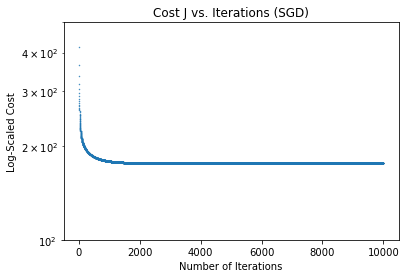

In [437]:
plt.scatter(range(10000), carr, s = 0.2)
plt.semilogy()
plt.ylim((1e2, 5e2))
plt.title("Cost J vs. Iterations (SGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

The flatlining above indicates either the learning rate is too high later on, or that it is near the minima but not at it. This indicates necessity for a dynamic learning rate.

I now tune for hyperparameters.  If we see below, what I do is make a grid of the possible hyperparameter permutations, and caculate the cost and validation accuracy in either case. With this information, I can make a guess as to what the ideal hyperparameter combination is. Above, I have redone my calculation with what I belive is near the optimal set of hyperparameters, based on the setup below.

In [413]:
lr_rng = np.logspace(-7, -2, 6)
reg_rng = np.logspace(-5, 2, 9)

In [414]:
def tune_hyp_gd(X, y, Xl, yl, lr_rng, reg_rng):
    hyps = np.array(np.meshgrid(lr_rng, reg_rng)).T
    arr_cost = np.zeros(hyps.shape[:2])
    arr_vacc = np.zeros(hyps.shape[:2])
    
    
    for i in range(len(lr_rng)):
        for j in range(len(reg_rng)):
            lr, reg = hyps[i][j]
            warr, carr = run_gd(regp, lr, n = 10000)
            vacc = get_vacc(Xl, yl, warr[-1])
            arr_vacc[i][j] = vacc
            arr_cost[i][j] = carr[-1]
    
    return arr_cost, arr_vacc, hyps
    
cost_gd, vacc_gd, hyps = tune_hyp_gd(X, y, Xl, yl, lr_rng, reg_rng)

/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


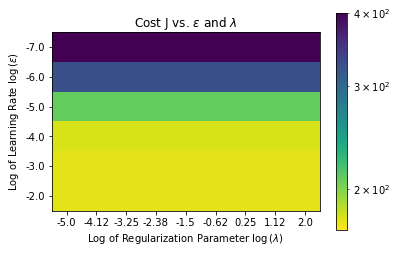

In [421]:
from matplotlib.colors import LogNorm
plt.imshow(cost_gd, cmap = 'viridis_r', norm = LogNorm(1.7e2, 4e2))
plt.xticks(range(9), np.round(np.log10(hyps[:, :, 1][0]), 2))
plt.yticks(range(6), np.round(np.log10(hyps[:, :].T[0][0])))
plt.title("Cost J vs. $\epsilon$ and $\lambda$")
plt.xlabel("Log of Regularization Parameter $\log{(\lambda)}$")
plt.ylabel("Log of Learning Rate $\log{(\epsilon)}$")
plt.colorbar()

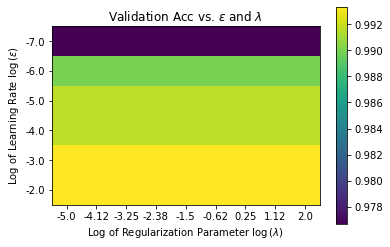

In [422]:
plt.imshow(vacc_gd)
plt.xticks(range(9), np.round(np.log10(hyps[:, :, 1][0]), 2))
plt.yticks(range(6), np.round(np.log10(hyps[:, :].T[0][0])))
plt.title("Validation Acc vs. $\epsilon$ and $\lambda$")
plt.xlabel("Log of Regularization Parameter $\log{(\lambda)}$")
plt.ylabel("Log of Learning Rate $\log{(\epsilon)}$")
plt.colorbar()

For highest validation accuracy and lowest cost, we need to use a high learning rate on the order of ~0.01. There is not a large dependence on the accuracy in varying the regularization in the range tested. This indicates that the value of lambda is too low to impact the cost function calculation significantly, hence not creating a significant effect here. However, higher values of lambda perform significantly worse. Therefore, we find that reducing this problem to a non-regularized logistic regression allows the best results. The "optimal hyperparameter values" of $\lambda = $ any low value and $\epsilon = 10^{-3}$ were done before the hyperparameter tuning.

### Question 3c
Refer to page before code section for Q3c, where the questions in the assignment are given (LaTeX portion of Document).

### Question 3d

Although the code is mostly the same, we modify the gradient descent to only take one point per iteration, and reset our numpy seed to 42.

In [380]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.special import expit
np.random.seed(42)

data = io.loadmat("prep_data_wine.mat")
X, y = prep_data(Xinit, yinit)
Xl, yl = prep_data(Xlinit, ylinit)

In [381]:
def run_sgd(regp, lr, n = 10000):

    def get_s(w):
        return expit(xi.dot(w))
    
    def get_s_vec(w):
        return expit(np.matmul(X, w))

    def desc_iter(w, i):
        s = get_s(w)
        b = (y[i] - s) * xi
        w_k = (1 - 2 * lr * regp) * w + lr * b
        return w_k

    def cost_fn(w):
        s = get_s_vec(w)
        cost = -(y.dot(np.log(s))) - (one - y).dot(np.log(one - s))
        return cost

    carr = []
    sarr = []
    warr = []
    w = np.zeros(X.shape[1])
    one = np.ones(X.shape[0])
    rand = np.random.randint(0, X.shape[0], size = n)
    for i in range(n):
        j = rand[i]
        xi = X[j]
        warr.append(w)
        carr.append(cost_fn(w))
        sarr.append(get_s(w))
        w = desc_iter(w, j)
    return warr, carr

def predict(X, w):
    a = np.matmul(X, w)
    return a > 0

def get_tacc(X, y, w):
    return np.sum(predict(X, w) == y) / len(y)

def get_vacc(Xl, yl, w):
    return np.sum(predict(Xl, w) == yl) / len(yl)

In [382]:
regp = 1e-5
lr = 0.1
warr, carr = run_sgd(regp, lr, n = 10000)

Below is the final cost of the optimization.

In [383]:
carr[-1]

209.09365088055512

Below is the training accuracy and number correct.

In [384]:
get_tacc(X, y, warr[-1])

0.9933333333333333

In [385]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5364 / 5400


Below is the validation accuracy and number correct.

In [386]:
get_vacc(Xl, yl, warr[-1])

0.9916666666666667

In [387]:
print(int(get_vacc(Xl, yl, warr[-1]) * len(yl)), "/" , len(yl))

595 / 600


Below is the cost function as a function of the number of iterations. The result for cost as a function of iterations is surprisingly stochastic, but it is likely due to the high learning rate input at the beginning. We find that this higher learning rate is better for a limited number of iterations (10000).

Text(0, 0.5, 'Log-Scaled Cost')

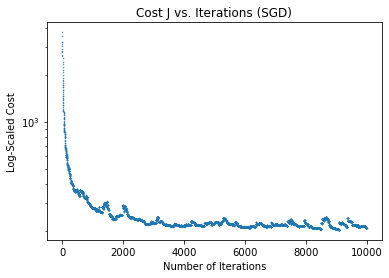

In [388]:
plt.scatter(range(10000), carr, s = 0.2)
plt.semilogy()
plt.title("Cost J vs. Iterations (SGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

I now tune for hyperparameters.  If we see below, what I do is make a grid of the possible hyperparameter permutations, and caculate the cost and validation accuracy in either case. With this information, I can make a guess as to what the ideal hyperparameter combination is. Above, I have redone my calculation with what I belive is near the optimal set of hyperparameters, based on the setup below.

In [389]:
lr_rng = np.logspace(-6, -1, 6)
reg_rng = np.logspace(-5, 2, 9)

In [ ]:
def tune_hyp(X, y, Xl, yl, lr_rng, reg_rng):
    hyps = np.array(np.meshgrid(lr_rng, reg_rng)).T
    arr_cost = np.zeros(hyps.shape[:2])
    arr_vacc = np.zeros(hyps.shape[:2])
    
    
    for i in range(len(lr_rng)):
        for j in range(len(reg_rng)):
            lr, reg = hyps[i][j]
            warr, carr = run_sgd(regp, lr, n = 10000)
            vacc = get_vacc(Xl, yl, warr[-1])
            arr_vacc[i][j] = vacc
            arr_cost[i][j] = carr[-1]
    
    return arr_cost, arr_vacc, hyps
    
cost_sgd, vacc_sgd, hyps = tune_hyp(X, y, Xl, yl, lr_rng, reg_rng)

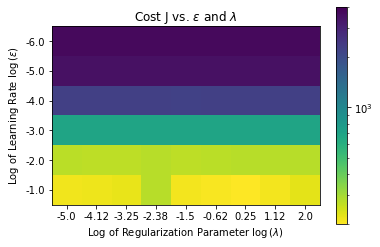

In [396]:
from matplotlib.colors import LogNorm
plt.imshow(cost_sgd, cmap = 'viridis_r', norm = LogNorm(2e2, 4e3))
plt.xticks(range(9), np.round(np.log10(hyps[:, :, 1][0]), 2))
plt.yticks(range(6), np.round(np.log10(hyps[:, :].T[0][0])))
plt.title("Cost J vs. $\epsilon$ and $\lambda$")
plt.xlabel("Log of Regularization Parameter $\log{(\lambda)}$")
plt.ylabel("Log of Learning Rate $\log{(\epsilon)}$")
plt.colorbar()

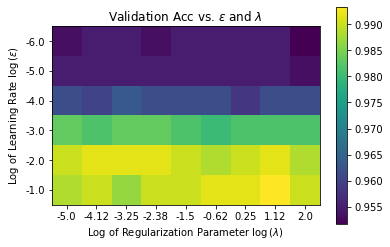

In [397]:
plt.imshow(vacc_sgd)
plt.xticks(range(9), np.round(np.log10(hyps[:, :, 1][0]), 2))
plt.yticks(range(6), np.round(np.log10(hyps[:, :].T[0][0])))
plt.title("Validation Acc vs. $\epsilon$ and $\lambda$")
plt.xlabel("Log of Regularization Parameter $\log{(\lambda)}$")
plt.ylabel("Log of Learning Rate $\log{(\epsilon)}$")
plt.colorbar()

For highest validation accuracy and lowest cost, therefore, we need to use a regularization parameter around 1 for this case, and a high learning rate, on the order of 0.1. The training done before the tuning was redone with this optimal set of hyperparameters.

### Question 3e

I will now implement an adaptive learning rate into SGD. We use the learning rate suggested in the homework, lr = lr_init / (iterations). We set the random seed to 24.

In [41]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.special import expit
np.random.seed(24)

data = io.loadmat("prep_data_wine.mat")

Xinit = data['training_data']
yinit = data['training_labels']
Xlinit = data['valid_data']
ylinit = data['valid_labels']

def prep_data(Xinit, yinit):
    Xinit = (Xinit - np.mean(Xinit, axis = 0)) / (np.std(Xinit, axis = 0) + 1e-3)
    j = np.ones(Xinit.shape[0])
    X = np.concatenate([Xinit, j[:, np.newaxis]], axis = 1)
    y = yinit.T[0]
    return X, y

data = io.loadmat("prep_data_wine.mat")
X, y = prep_data(Xinit, yinit)
Xl, yl = prep_data(Xlinit, ylinit)

In [42]:
def run_adasgd(regp, lr, n = 10000):

    def get_s(w):
        return expit(xi.dot(w))
    
    def get_s_vec(w):
        a = expit(np.matmul(X, w))
        if 1 in a:
            a[np.where(a == 1)] = 0.9999
        return a

    def desc_iter(w, i):
        lr_iter = lr / (i + 1) # ADAPTIVE LEARNING RATE IMPLEMENTED
        s = get_s(w)
        b = (y[i] - s) * xi
        w_k = (1 - 2 * lr_iter * regp) * w + lr_iter * b
        return w_k

    def cost_fn(w):
        s = get_s_vec(w)
        cost = -(y.dot(np.log(s))) - (one - y).dot(np.log(one - s))
        return cost

    carr = []
    warr = []
    w = np.zeros(X.shape[1])
    one = np.ones(X.shape[0])
    rand = np.random.randint(0, X.shape[0], size = n)
    for i in range(n):
        j = rand[i]
        xi = X[j]
        warr.append(w)
        carr.append(cost_fn(w))
        w = desc_iter(w, j)
    return warr, carr

def predict(X, w):
    a = np.matmul(X, w)
    return a > 0

def get_tacc(X, y, w):
    return np.sum(predict(X, w) == y) / len(y)

def get_vacc(Xl, yl, w):
    return np.sum(predict(Xl, w) == yl) / len(yl)

In [43]:
regp = 1e-4
lr = 10
warr, carr = run_adasgd(regp, lr, n = 10000)

Below is the final cost of the optimization.

In [44]:
carr[-1]

270.98773491788694

Below is the training accuracy and number correct.

In [45]:
get_tacc(X, y, warr[-1])

0.9892592592592593

In [46]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5342 / 5400


Below is the validation accuracy and number correct.

In [47]:
get_vacc(Xl, yl, warr[-1])

0.9883333333333333

In [48]:
print(int(get_vacc(Xl, yl, warr[-1]) * len(yl)), "/" , len(yl))

593 / 600


Below is the cost function as a function of the number of iterations. The result for cost as a function of iterations is surprisingly stochastic, but it is likely due to the high learning rate input at the beginning. We find that this higher learning rate is better for a limited number of iterations (10000).

Text(0, 0.5, 'Log-Scaled Cost')

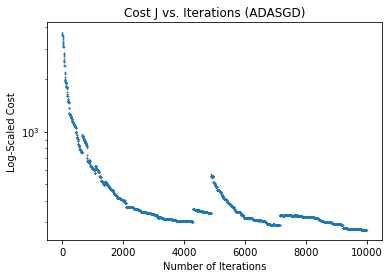

In [49]:
plt.scatter(range(10000), carr, s = 0.2)
plt.semilogy()
plt.title("Cost J vs. Iterations (ADASGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

In [36]:
lr_rng = np.logspace(-3, 2, 6)
reg_rng = np.logspace(-5, 2, 9)

In [37]:
def tune_hyp_ada(X, y, Xl, yl, lr_rng, reg_rng):
    hyps = np.array(np.meshgrid(lr_rng, reg_rng)).T
    arr_cost = np.zeros(hyps.shape[:2])
    arr_vacc = np.zeros(hyps.shape[:2])
    
    
    for i in range(len(lr_rng)):
        for j in range(len(reg_rng)):
            lr, reg = hyps[i][j]
            warr, carr = run_adasgd(regp, lr, n = 10000)
            vacc = get_vacc(Xl, yl, warr[-1])
            arr_vacc[i][j] = vacc
            arr_cost[i][j] = carr[-1]
    
    return arr_cost, arr_vacc, hyps
    
cost_ada, vacc_ada, hyps = tune_hyp_ada(X, y, Xl, yl, lr_rng, reg_rng)

/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


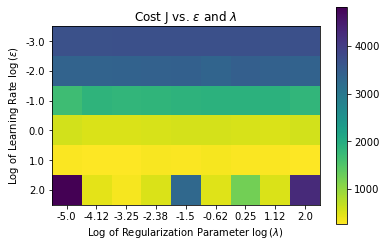

In [38]:
from matplotlib.colors import LogNorm
plt.imshow(cost_ada, cmap = 'viridis_r')#, norm = LogNorm(2e2, 4e3))
plt.xticks(range(9), np.round(np.log10(hyps[:, :, 1][0]), 2))
plt.yticks(range(6), np.round(np.log10(hyps[:, :].T[0][0])))
plt.title("Cost J vs. $\epsilon$ and $\lambda$")
plt.xlabel("Log of Regularization Parameter $\log{(\lambda)}$")
plt.ylabel("Log of Learning Rate $\log{(\epsilon)}$")
plt.colorbar()

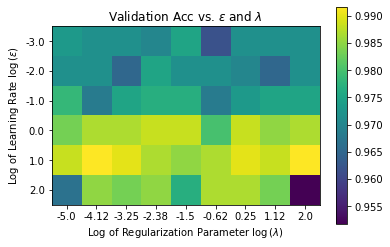

In [39]:
plt.imshow(vacc_ada)
plt.xticks(range(9), np.round(np.log10(hyps[:, :, 1][0]), 2))
plt.yticks(range(6), np.round(np.log10(hyps[:, :].T[0][0])))
plt.title("Validation Acc vs. $\epsilon$ and $\lambda$")
plt.xlabel("Log of Regularization Parameter $\log{(\lambda)}$")
plt.ylabel("Log of Learning Rate $\log{(\epsilon)}$")
plt.colorbar()

For highest validation accuracy and lowest cost, therefore, we need to use a regularization parameter around 1e-4 for this case, and a high learning rate, on the order of 10. The training done before the tuning was redone with this optimal set of hyperparameters. There is some stochasticity in these results due to lack of significant cross validation. However, it was mentioned on Piazza that we would not be penalized for not performing crossvalidation.

### Question 3f

**Kaggle Username: Shrihan Agarwal**  
**Kaggle Score: 98.792**  


For Kaggle, I take the SGD from the previous part, increase the number of iterations to 100000, and reduce the regp value to 0, removing regularization. Additionally, I implement a modified learning rate, which drops as:  
0.1: 1 - 1000  
0.015: 1000-5000  
1e-2: 5000-10000  
1e-3: 10000-50000  
1e-5: 50000-100000  
iterations. We set the random seed to 24.

In [65]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.special import expit
np.random.seed(24)

data = io.loadmat("prep_data_wine.mat")

Xinit = data['training_data']
yinit = data['training_labels']
Xlinit = data['valid_data']
ylinit = data['valid_labels']

def prep_data(Xinit, yinit):
    Xinit = (Xinit - np.mean(Xinit, axis = 0)) / (np.std(Xinit, axis = 0) + 1e-3)
    j = np.ones(Xinit.shape[0])
    X = np.concatenate([Xinit, j[:, np.newaxis]], axis = 1)
    y = yinit.T[0]
    return X, y

data = io.loadmat("prep_data_wine.mat")
X, y = prep_data(Xinit, yinit)
Xl, yl = prep_data(Xlinit, ylinit)

In [66]:
def run_optsgd(regp, n = 10000):
    
    def lr_scheduler(it):
        if it < 1000:
            return 0.1
        elif it < 5000:
            return 0.015
        elif it < 10000:
            return 1e-2
        elif it < 50000:
            return 1e-3
        else:
            return 1e-5

    def get_s(w):
        return expit(xi.dot(w))
    
    def get_s_vec(w):
        a = expit(np.matmul(X, w))
        #if 1 in a:
        #    a[np.where(a == 1)] = 0.9999
        return a

    def desc_iter(w, i, j):
        lr_fix = 0.1
        lr_iter = lr_scheduler(i) # ADAPTIVE LEARNING RATE IMPLEMENTED
        s = get_s(w)
        b = (y[j] - s) * xi
        w_k = (1 - 2 * lr_iter * regp) * w + lr_iter * b
        return w_k

    def cost_fn(w):
        s = get_s_vec(w)
        cost = -(y.dot(np.log(s))) - (one - y).dot(np.log(one - s))
        return cost

    carr = []
    warr = []
    w = np.zeros(X.shape[1])
    one = np.ones(X.shape[0])
    rand = np.random.randint(0, X.shape[0], size = n)
    for i in range(n):
        j = rand[i]
        xi = X[j]
        warr.append(w)
        carr.append(cost_fn(w))
        w = desc_iter(w, i, j)
    return warr, carr

def predict(X, w):
    a = np.matmul(X, w)
    return a > 0

def get_tacc(X, y, w):
    return np.sum(predict(X, w) == y) / len(y)

def get_vacc(Xl, yl, w):
    return np.sum(predict(Xl, w) == yl) / len(yl)

In [67]:
regp = 0
warr, carr = run_optsgd(regp, n = 100000)

Below is the final cost of the optimization.

In [68]:
carr[-1]

226.93814805283512

Below is the training accuracy and number correct.

In [69]:
get_tacc(X, y, warr[-1])

0.9912962962962963

In [70]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5353 / 5400


Below is the validation accuracy and number correct.

In [71]:
get_vacc(Xl, yl, warr[-1])

0.99

In [72]:
print(int(get_vacc(Xl, yl, warr[-1]) * len(yl)), "/" , len(yl))

594 / 600


Below is the cost function as a function of the number of iterations. The result for cost as a function of iterations is surprisingly stochastic, but it is likely due to the high learning rate input at the beginning. We find that this higher learning rate is better for a limited number of iterations (10000).

Text(0, 0.5, 'Log-Scaled Cost')

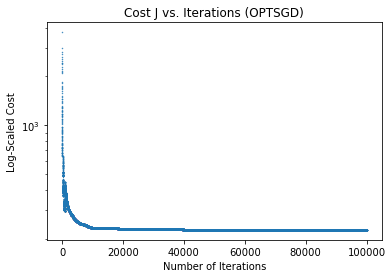

In [73]:
plt.scatter(range(100000), carr, s = 0.2)
plt.semilogy()
plt.title("Cost J vs. Iterations (OPTSGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

In [128]:
Xtot = data['X']
ytot = data['y']
Xtest = data['X_test']

X, y = prep_data(Xtot, ytot)
Xt, yt = prep_data(Xtest, y)

In [129]:
regp = 0
warr, carr = run_optsgd(regp, n = 100000)

In [130]:
carr[-1]

250.9119945114058

In [131]:
get_tacc(X, y, warr[-1])

0.991

In [132]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5946 / 6000


Text(0, 0.5, 'Log-Scaled Cost')

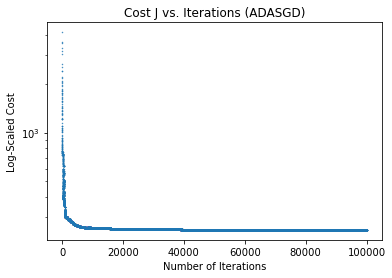

In [133]:
plt.scatter(range(100000), carr, s = 0.2)
plt.semilogy()
plt.title("Cost J vs. Iterations (ADASGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

In [139]:
pred = predict(Xt, warr[-1])

In [141]:
idx = list(range(1, len(pred) + 1))

In [143]:
pre_csv = np.array(list(zip(idx, pred)), dtype = int)

In [144]:
np.savetxt("shri_pred_optsgd.csv", pre_csv, fmt = '%s', delimiter=',')

The above did not perform so well, with an accuracy of only 98.784. I try other methods, but they don't seem to do significantly better on Kaggle.

**Kaggle Username: Shrihan Agarwal**  
**Kaggle Score: 98.792**  


### Other Attempts for 3f

Below, we return to a normal GD method for Kaggle, with an adaptive learning rate, according to the LR scheduler function I created, which starts at 1e-2, and drops progressively by multiples of 10 at 1000, 5000, 10000 iterations.

In [64]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.special import expit
np.random.seed(42)

data = io.loadmat("prep_data_wine.mat")

Xinit = data['training_data']
yinit = data['training_labels']
Xlinit = data['valid_data']
ylinit = data['valid_labels']

def prep_data(Xinit, yinit):
    Xinit = (Xinit - np.mean(Xinit, axis = 0)) / (np.std(Xinit, axis = 0) + 1e-3)
    j = np.ones(Xinit.shape[0])
    X = np.concatenate([Xinit, j[:, np.newaxis]], axis = 1)
    y = yinit.T[0]
    return X, y

data = io.loadmat("prep_data_wine.mat")
X, y = prep_data(Xinit, yinit)
Xl, yl = prep_data(Xlinit, ylinit)

In [44]:
def run_mod_gd(regp, n = 10000):
    
    def lr_scheduler(it):
        if it < 1000:
            return 1e-2
        elif it < 5000:
            return 1e-3
        elif it < 10000:
            return 1e-4
    
    def get_s(w):
        return expit(np.matmul(X, w))

    w = np.zeros(X.shape[1])
    one = np.ones(X.shape[0])

    def desc_iter(w, i):
        s = get_s(w)
        lr = lr_scheduler(i)
        b = np.matmul(X.T, y - s)
        w_k = (1 - 2 * lr * regp) * w + lr * b
        return w_k

    def cost_fn(w):
        s = get_s(w)
        cost = -(y.dot(np.log(s))) - (one - y).dot(np.log(one - s))
        return cost

    carr = []
    sarr = []
    warr = []
    for i in range(n):
        warr.append(w)
        carr.append(cost_fn(w))
        sarr.append(get_s(w))
        w = desc_iter(w, i)
    return warr, carr

def predict(X, w):
    a = np.matmul(X, w)
    return a > 0

def get_tacc(X, y, w):
    return np.sum(predict(X, w) == y) / len(y)

def get_vacc(Xl, yl, w):
    return np.sum(predict(Xl, w) == yl) / len(yl)

In [45]:
regp = 0
warr, carr = run_mod_gd(regp, n = 10000)

/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


Below is the final cost of the optimization.

In [46]:
carr[-1]

176.23354305067517

Below is the training accuracy and number correct.

In [47]:
get_tacc(X, y, warr[-1])

0.9953703703703703

In [48]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5375 / 5400


Below is the validation accuracy and number correct.

In [49]:
get_vacc(Xl, yl, warr[-1])

0.9933333333333333

In [50]:
print(int(get_vacc(Xl, yl, warr[-1]) * len(yl)), "/" , len(yl))

596 / 600


Below is the cost function as a function of the number of iterations. The result for cost as a function of iterations is surprisingly stochastic, but it is likely due to the high learning rate input at the beginning. We find that this higher learning rate is better for a limited number of iterations (10000).

Text(0, 0.5, 'Log-Scaled Cost')

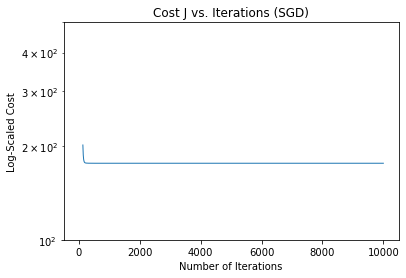

In [51]:
plt.plot(range(10000), carr, lw = 1)
plt.semilogy()
plt.ylim((1e2, 5e2))
plt.title("Cost J vs. Iterations (SGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

In [52]:
Xtot = data['X']
ytot = data['y']
Xtest = data['X_test']

X, y = prep_data(Xtot, ytot)
Xt, yt = prep_data(Xtest, y)

In [54]:
regp = 0
warr, carr = run_mod_gd(regp, n = 10000)

/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


In [55]:
carr[-1]

196.6900080342118

In [56]:
get_tacc(X, y, warr[-1])

0.9951666666666666

In [57]:
print(int(get_tacc(X, y, warr[-1]) * len(y)), "/" , len(y))

5971 / 6000


Text(0, 0.5, 'Log-Scaled Cost')

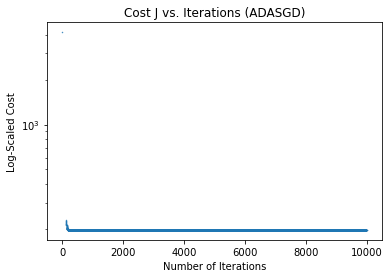

In [59]:
plt.scatter(range(10000), carr, s = 0.2)
plt.semilogy()
plt.title("Cost J vs. Iterations (ADASGD)")
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Scaled Cost")

In [60]:
pred = predict(Xt, warr[-1])

In [61]:
idx = list(range(1, len(pred) + 1))

In [62]:
pre_csv = np.array(list(zip(idx, pred)), dtype = int)

In [63]:
np.savetxt("shri_pred_optmodgd.csv", pre_csv, fmt = '%s', delimiter=',')

Here, I add the ID,Category manually. This did not perform as well as expected either, unfortunately, performing worse than the earlier method with larger iterations of SGD. My final choice for submission was the optsgd.csv file.

**Kaggle Username: Shrihan Agarwal**  
**Kaggle Score: 98.792**  


## Question 5

### Question 5a

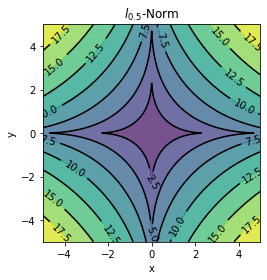

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as mnorm
plt.rcParams["figure.figsize"] = (4,4)

def p_norm(x, y, p):
    w = np.array([x, y])
    return np.sum((np.abs(w) ** p), axis = 0) ** (1/p)

mn = [1, 1]
cov = [[1, 0], [0, 2]]

x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, p_norm(X, Y, 0.5), 8, alpha=.75, cmap="viridis")
C = plt.contour(X, Y, p_norm(X, Y, 0.5), 8, colors='k')
plt.clabel(C, inline=1, fontsize=10)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("$l_{0.5}$-Norm")

plt.show()

### Question 5b

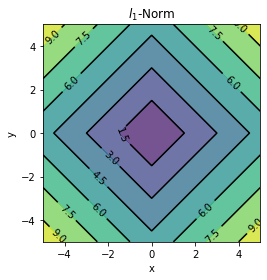

In [37]:
plt.contourf(X, Y, p_norm(X, Y, 1), 8, alpha=.75, cmap="viridis")
C = plt.contour(X, Y, p_norm(X, Y, 1), 8, colors='k')
plt.clabel(C, inline=1, fontsize=10)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("$l_1$-Norm")
plt.show()

### Question 5c

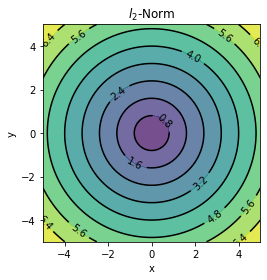

In [38]:
plt.contourf(X, Y, p_norm(X, Y, 2), 8, alpha=.75, cmap="viridis")
C = plt.contour(X, Y, p_norm(X, Y, 2), 8, colors='k')
plt.clabel(C, inline=1, fontsize=10)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("$l_2$-Norm")
plt.show()